In [1]:
import sys
from time import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append("..")
sys.path.append("../base_networks/segmentation/")
from dataset import Pipeline, DatasetIndex, Dataset, B, C, F, V

from linknet import LinkNetModel                                  # TFModel subclass with LinkNet
from nmnist import NoisedMnist                                          # Batch subclass with loading and noise actions
from plot_functions import plot_noised_image, plot_examples_highlighted # plot functions to demonstrate result 

%matplotlib inline

In [2]:
BATCH_SIZE = 256   # batch size for NN training
MAX_ITER = 100     # number of iterations for NN training
SIZE = 50000
IMAGE_SIZE = 64

In [3]:
images = []
masks = []
for i in tqdm(range(SIZE)):
    data = np.sin(np.random.uniform(0, 2*np.pi) + np.arange(0, IMAGE_SIZE) / IMAGE_SIZE * 2*np.pi )
    mask = data > 0.25
    images.append(data)
    masks.append(mask)
images = np.array(images)
masks = np.array(masks)
masks = np.stack([1-masks, masks], axis=2)

100%|█████████████████████████████████| 50000/50000 [00:00<00:00, 55040.98it/s]


In [4]:
ind = DatasetIndex(np.arange(SIZE))          # index for images
dset = Dataset(ind, batch_class=NoisedMnist)   # Dataset with transform actions in NoisedMnist class
dset.cv_split([0.9, 0.1])                      # divide it into train and test

In [5]:
load_template = Pipeline().load(src=(images, masks), components=('images', 'masks'))

In [6]:
placeholders_config = {
                       'images': {'shape': (IMAGE_SIZE, 1),
                                  'type': 'float32',
                                  'data_format': 'channels_last'},
                
                       'masks': {'shape': (IMAGE_SIZE, 2),
                                 'type': 'int32',
                                 'data_format': 'channels_last',
                                 'name': 'targets'}
                       }

In [7]:
model_config = {'inputs': placeholders_config,
                'n_classes': 2,
                'batch_norm': False,
                'loss': 'softmax_cross_entropy',
                'optimizer': 'Adam'}

In [8]:
train_feed_dict = {'images': B('images'),
                   'masks': B('masks')}        

test_feed_dict = {'images': B('images'),
                  'masks': B('masks')}

In [9]:
ppl_train = ((load_template << dset.train)
            .init_variable('train_loss_history', init_on_each_run=list)
            .init_model('static',                                          # model mode
                        LinkNetModel,                                      # TFModel subclass with LinkNet
                        'linknet',                                         # model name
                        config=model_config)
            .train_model('linknet',                                        # model name
                         fetches='loss',                                   # tensors to get value 
                         feed_dict=train_feed_dict,
                         save_to=[V('train_loss_history')], mode='a'))                  # name of pipeline variable to save loss value

ppl_test = ((load_template << dset.test)
            .import_model('linknet', ppl_train)
            .init_variable('test_loss_history', init_on_each_run=list)
            .predict_model('linknet', 
                           fetches='loss',
                           feed_dict=test_feed_dict,
                           save_to=[V('test_loss_history')], mode='a'))

Tensor("predictions:0", shape=(?, 64, 2), dtype=float32)


In [10]:
# training of the model

start = time()

for i in range(MAX_ITER):
    ppl_train.next_batch(BATCH_SIZE, n_epochs=None)                              # training step
    ppl_test.next_batch(100, n_epochs=None)                                      # compute test loss
    
    train_loss = ppl_train.get_variable('train_loss_history')[-1]                # get current iteration train loss
    test_loss = ppl_test.get_variable('test_loss_history')[-1]                   # get current iteration test loss
    
    if (i+1) % 1 == 0:
        print("Iter {:3d}: train {:05.3f} test {:05.3f}".format(i+1, train_loss, test_loss))
        
stop = time()

print("Train time: {:05.3f} min".format((stop-start)/60))

Iter   1: train 1.385 test 1.379
Iter   2: train 1.380 test 1.371
Iter   3: train 1.372 test 1.359
Iter   4: train 1.358 test 1.338
Iter   5: train 1.337 test 1.306
Iter   6: train 1.304 test 1.261
Iter   7: train 1.253 test 1.197
Iter   8: train 1.190 test 1.126
Iter   9: train 1.115 test 1.057
Iter  10: train 1.040 test 0.996
Iter  11: train 0.975 test 0.909
Iter  12: train 0.917 test 0.869
Iter  13: train 0.866 test 0.836
Iter  14: train 0.837 test 0.805
Iter  15: train 0.803 test 0.784
Iter  16: train 0.780 test 0.767
Iter  17: train 0.763 test 0.750
Iter  18: train 0.745 test 0.731
Iter  19: train 0.737 test 0.719
Iter  20: train 0.719 test 0.710
Iter  21: train 0.706 test 0.696
Iter  22: train 0.696 test 0.693
Iter  23: train 0.681 test 0.674
Iter  24: train 0.674 test 0.669
Iter  25: train 0.669 test 0.665
Iter  26: train 0.662 test 0.653
Iter  27: train 0.658 test 0.655
Iter  28: train 0.653 test 0.641
Iter  29: train 0.648 test 0.641
Iter  30: train 0.644 test 0.635
Iter  31: 

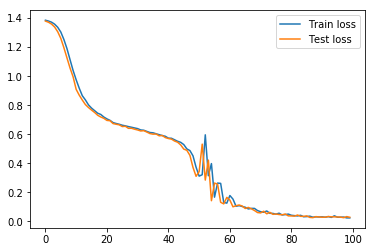

In [11]:
plt.plot(ppl_train.get_variable('train_loss_history'), label='Train loss')
plt.plot(ppl_test.get_variable('test_loss_history'), label='Test loss')
plt.legend()
plt.show()